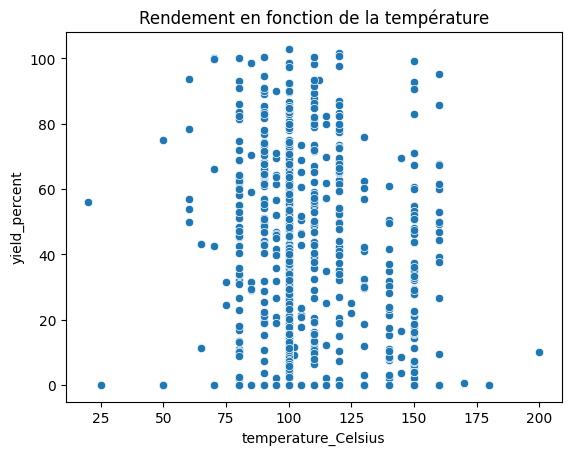

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import seaborn as sns

df = pd.read_csv("datas/buchwald_full_clean.csv")

sns.scatterplot(x="temperature_Celsius", y="yield_percent", data=df)
plt.title("Rendement en fonction de la température")
plt.show()

In [2]:
morgan_gen = GetMorganGenerator(radius=3, fpSize=2048)

def mol_to_fp(smiles):
    if not isinstance(smiles, str) or smiles.strip() == "":
        return np.zeros((2048,))
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((2048,))
    return np.array(morgan_gen.GetFingerprint(mol))

fps_base = np.array([mol_to_fp(s) for s in df['inputs_base_SMILES']])
fps_solvent = np.array([mol_to_fp(s) for s in df['inputs_solvent_SMILES']])
fps_amine= np.array([mol_to_fp(s) for s in df['inputs_amine_SMILES']])
fps_aryl_halide= np.array([mol_to_fp(s) for s in df['inputs_aryl_halide_SMILES']])

# First, find the maximum length in fps_base, fps_solvent, etc., and store it in max_length
max_length = max(fps_base.shape[1], fps_solvent.shape[1], fps_amine.shape[1], fps_aryl_halide.shape[1])

# Then, pad each fingerprint with zeroes until its length is equal to max_length
fps_base = np.pad(fps_base, ((0, 0), (0, max_length - fps_base.shape[1])))
fps_solvent = np.pad(fps_solvent, ((0, 0), (0, max_length - fps_solvent.shape[1])))
fps_amine = np.pad(fps_amine, ((0, 0), (0, max_length - fps_amine.shape[1])))
fps_aryl_halide = np.pad(fps_aryl_halide, ((0, 0), (0, max_length - fps_aryl_halide.shape[1])))

X_fp = np.hstack([fps_base, fps_solvent, fps_amine, fps_aryl_halide])

[13:51:31] WARNING: not removing hydrogen atom without neighbors


In [3]:
X = np.hstack([df[['temperature_Celsius']].values, X_fp])
y = df['yield_percent'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [4]:
# Define the NN model
class Net(torch.nn.Module):     # Define model architecture
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 32)   # Input layer (8192 features)
        self.fc2 = torch.nn.Linear(32, 32)           # Hidden layer
        self.fc3 = torch.nn.Linear(32, 1)            # Output layer (single output for yield prediction)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x).squeeze()                  # Remove the last dimension (since target is 1D)



In [5]:
# Define model, loss function and optimizer
model = Net(8192)   # Input dimension should match your fingerprint vector size
criterion = torch.nn.MSELoss()    # Mean Squared Error Loss for regression problems
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [6]:
# Convert numpy arrays to PyTorch Dataset for training and validation 
train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset  = Data.TensorDataset(torch.from_numpy(X_test ).float(), torch.from_numpy(y_test ).float())

# Define a data loader for training and validation 
batch_size = 32  # You can adjust this value according to your needs
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
# Train the model
for epoch in range(100):   
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data   # Labels are now 1D tensors of length batch_size
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()     
        outputs = model(inputs)     # Outputs will also be 1D tensors of length batch_size
        loss = criterion(outputs, labels)
        loss.backward()            
        optimizer.step()           
        running_loss += loss.item() * inputs.size(0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x8193 and 8192x32)

In [8]:
# Predicting on test data and evaluating the model
X_test = torch.tensor(X_test, dtype=torch.float32)
if torch.cuda.is_available():
    X_test = X_test.to('cuda')
y_pred = model(X_test).detach().numpy()   # Convert to numpy array if using GPU
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² sur test  : {r2_score(y_test, y_pred):.3f}")
print(f"RMSE sur test: {rmse:.3f}")

R² sur test  : -0.048
RMSE sur test: 31.064
